In [2]:
import io
import time
import sys
import numpy as np
import platform
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt
 
import cv2
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials

In [7]:
SUBSCRIPTION_KEY = "2bc5731acc9543aa954320afc007684a"
ENDPOINT_URL = "https://sssssu.cognitiveservices.azure.com/"
 
computervision_client = ComputerVisionClient(ENDPOINT_URL, CognitiveServicesCredentials(SUBSCRIPTION_KEY))

In [24]:
path = '../data/test/test_00001.png'
with open(path, 'rb') as f:
    data = f.read()
sbuf = io.BytesIO(data)


In [25]:
response = computervision_client.read_in_stream(sbuf, raw=True)
operationLocation = response.headers["Operation-Location"]
operationID = operationLocation.split("/")[-1]

In [11]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [12]:
def put_text(image, text, x, y, color=(0, 255, 0), font_size=22):
    if type(image) == np.ndarray:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(color_coverted)
 
    if platform.system() == 'Darwin':
        font = 'AppleGothic.ttf'
    elif platform.system() == 'Windows':
        font = 'malgun.ttf'
        
    image_font = ImageFont.truetype(font, font_size)
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
 
    draw.text((x, y), text, font=image_font, fill=color)
    
    numpy_image = np.array(image)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
 
    return opencv_image

5元


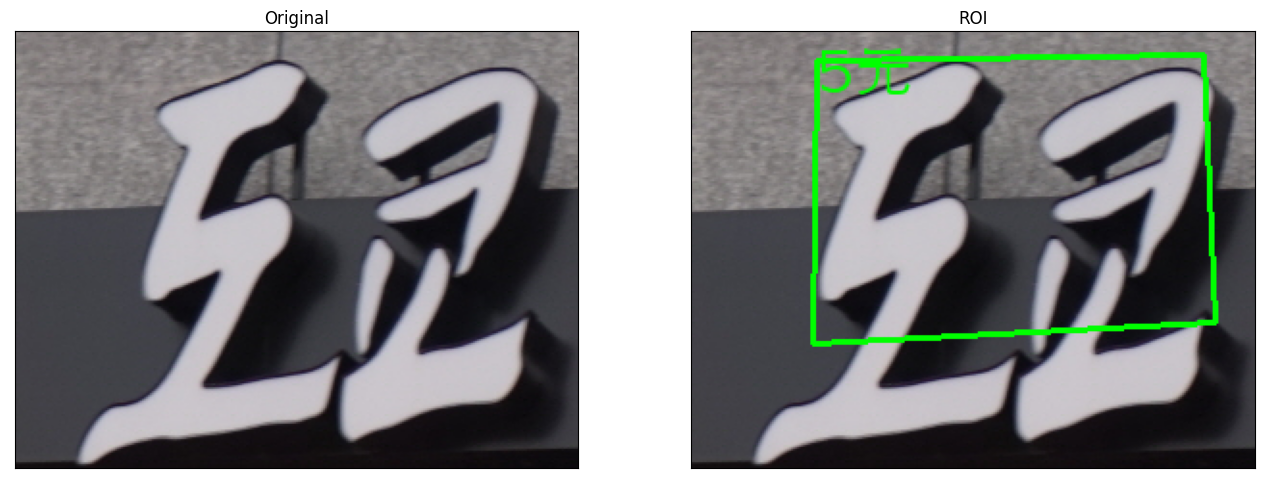

In [26]:
while True:
    read_result = computervision_client.get_read_result(operationID)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)
 
if read_result.status == OperationStatusCodes.succeeded:
    img = cv2.imread(path)
    roi_img = img.copy()
 
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            text = line.text
            box = list(map(int, line.bounding_box))
            (tlX, tlY, trX, trY, brX, brY, blX, blY) = box
            pts = ((tlX, tlY), (trX, trY), (brX, brY), (blX, blY))
 
            topLeft = pts[0]
            topRight = pts[1]
            bottomRight = pts[2]
            bottomLeft = pts[3]
 
            cv2.line(roi_img, topLeft, topRight, (0,255,0), 2)
            cv2.line(roi_img, topRight, bottomRight, (0,255,0), 2)
            cv2.line(roi_img, bottomRight, bottomLeft, (0,255,0), 2)
            cv2.line(roi_img, bottomLeft, topLeft, (0,255,0), 2)
            roi_img = put_text(roi_img, text, topLeft[0], topLeft[1] - 10, font_size=30)
 
            print(text)
            
    plt_imshow(["Original", "ROI"], [img, roi_img], figsize=(16, 10))

In [20]:
text

'미'